# Multi-Agent Deep Reinforcement Learning

## Tennis Environment

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print("Environment Brain: ", brain_name)

Environment Brain:  TennisBrain


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
import torch
from d4pg_multiagent import multiAgent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
TARGET_SCORE   = 0.5               # the main project goal
ULTIMATE_SCORE = 1.5               # A challenging milestone

Agent1_Actor_checkpoint_target_file  = "Agent1_Actor_checkpoint_target.pth"
Agent1_Critic_checkpoint_target_file = "Agent1_Critic_checkpoint_target.pth"

Agent2_Actor_checkpoint_target_file  = "Agent2_Actor_checkpoint_target.pth"
Agent2_Critic_checkpoint_target_file = "Agent2_Critic_checkpoint_target.pth"

Agent1_Actor_checkpoint_latest_file  = "Agent1_Actor_checkpoint_latest.pth"
Agent1_Critic_checkpoint_latest_file = "Agent1_Critic_checkpoint_latest.pth"

Agent2_Actor_checkpoint_latest_file  = "Agent2_Actor_checkpoint_latest.pth"
Agent2_Critic_checkpoint_latest_file = "Agent2_Critic_checkpoint_latest.pth"

Scores_data_logging_file             = "Highest_Scores_logging_checkpoint.pth"

def d4pg_training(n_episodes=10000, Solved=False):
    
    """Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #env=None
    #env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
    #brain_name = env.brain_names[0]
    #brain = env.brains[brain_name]
    
    scores             = []
    Agent1_scores      = []
    Agent2_scores      = []                 # list containing scores from each episode
    Rolling_avg_scores = []
    scores_window      = deque(maxlen=100)  # last 100 scores
    Max_Rolling_Scores = 0.0
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states   = env_info.vector_observations
        Agent1_score  = 0
        Agent2_score  = 0
        
        while True:
            actions      = multiagent.acts(states)
            env_info     = env.step(actions)[brain_name]
            next_states  = env_info.vector_observations
            rewards      = env_info.rewards
            dones        = env_info.local_done
            
            multiagent.step(states, actions, rewards, next_states, dones)
            states  = next_states
            Agent1_score += rewards[0]
            Agent2_score += rewards[1]
            
            if dones[0]:
                break

        score  =  max(Agent1_score, Agent2_score)        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        Agent1_scores.append(Agent1_score)
        Agent2_scores.append(Agent2_score)
        
        # Calculate the scores of the rolling 100 episodes 
        rolling_100_scores = np.mean(scores_window)
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, rolling_100_scores), end="")
        Rolling_avg_scores.append(rolling_100_scores)
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, rolling_100_scores))
               
        if rolling_100_scores > TARGET_SCORE and not Solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, 
                                                                                         rolling_100_scores))
            torch.save(multiagent.d4pg_Agents[0].actor_local.state_dict(),  Agent1_Actor_checkpoint_target_file)
            torch.save(multiagent.d4pg_Agents[0].critic_local.state_dict(), Agent1_Critic_checkpoint_target_file)
            
            torch.save(multiagent.d4pg_Agents[1].actor_local.state_dict(),  Agent2_Actor_checkpoint_target_file)
            torch.save(multiagent.d4pg_Agents[1].critic_local.state_dict(), Agent2_Critic_checkpoint_target_file)
            
            Solved = True
        
        if rolling_100_scores > Max_Rolling_Scores:
            print('\nNew Peak in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, 
                                                                               rolling_100_scores))
            torch.save(multiagent.d4pg_Agents[0].actor_local.state_dict(),  Agent1_Actor_checkpoint_latest_file)
            torch.save(multiagent.d4pg_Agents[0].critic_local.state_dict(), Agent1_Critic_checkpoint_latest_file)
            
            torch.save(multiagent.d4pg_Agents[1].actor_local.state_dict(),  Agent2_Actor_checkpoint_latest_file)
            torch.save(multiagent.d4pg_Agents[1].critic_local.state_dict(), Agent2_Critic_checkpoint_latest_file)
            
        if rolling_100_scores > Max_Rolling_Scores:
            Max_Rolling_Scores = rolling_100_scores
            torch.save({
                'scores': scores,
                'Agent1_scores': Agent1_scores,
                'Agent2_scores': Agent2_scores,
                'Avg_scores'   : Rolling_avg_scores
            }, Scores_data_logging_file)
            
        if Max_Rolling_Scores > ULTIMATE_SCORE:
            print('\nThe Ultimate Peak reached in {:d} episodes!\twith rolling Score: {:.4f}'
                  .format(i_episode-100, Max_Rolling_Scores))
            break
    
    env.close()
    
    return scores, Agent1_scores, Agent2_scores

In [ ]:
import time

# train multi agents with D4PG
multiagent = multiAgent(state_size=state_size, action_size=action_size, seed=1, 
                        BUFFER_SIZE=int(1e6), BATCH_SIZE=64, GAMMA=0.97, TAU=1e-3, 
                        LR_ACTOR=5e-4, LR_CRITIC=5e-4, WEIGHT_DECAY=0.0, UPDATE_EVERY=2, N_step=5)

start_time = time.time()                                 # Monitor Training Time
scores, Agent1_scores, Agent2_scores = d4pg_training(n_episodes=30000)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 100	Average Score: 0.0000
Episode 200	Average Score: 0.0000
Episode 237	Average Score: 0.0010
New Peak in 237 episodes!	Average Score: 0.0010
Episode 238	Average Score: 0.0020
New Peak in 238 episodes!	Average Score: 0.0020
Episode 240	Average Score: 0.0050
New Peak in 240 episodes!	Average Score: 0.0050
Episode 300	Average Score: 0.0050
Episode 400	Average Score: 0.0000
Episode 500	Average Score: 0.0010
Episode 534	Average Score: 0.0059
New Peak in 534 episodes!	Average Score: 0.0059
Episode 538	Average Score: 0.0068
New Peak in 538 episodes!	Average Score: 0.0068
Episode 539	Average Score: 0.0077
New Peak in 539 episodes!	Average Score: 0.0077
Episode 542	Average Score: 0.0086
New Peak in 542 episodes!	Average Score: 0.0086
Episode 544	Average Score: 0.0095
New Peak in 544 episodes!	Average Score: 0.0095
Episode 548	Average Score: 0.0104
New Peak in 548 episodes!	Average Score: 0.0104
Episode 549	Average Score: 0.0113
New Peak in 549 episodes!	Average Score: 0.0113
Episode 55

C:\MyFiles\Research\MachineLearning\DRLND\deep-reinforcement-learning-master\p3_collab-compet\WAF_P3.2\d4pg_agent.py:147: RuntimeWarning: divide by zero encountered in power
  is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
C:\MyFiles\Research\MachineLearning\DRLND\deep-reinforcement-learning-master\p3_collab-compet\WAF_P3.2\d4pg_agent.py:149: RuntimeWarning: invalid value encountered in true_divide
  is_weight /= is_weight.max()


(64,)
Episode 1045	Average Score: 0.0610
New Peak in 1045 episodes!	Average Score: 0.0610
Episode 1046	Average Score: 0.0620
New Peak in 1046 episodes!	Average Score: 0.0620
Episode 1048	Average Score: 0.0628
New Peak in 1048 episodes!	Average Score: 0.0628
Episode 1051	Average Score: 0.0638
New Peak in 1051 episodes!	Average Score: 0.0638
Episode 1062	Average Score: 0.0644
New Peak in 1062 episodes!	Average Score: 0.0644
Episode 1063	Average Score: 0.0645
New Peak in 1063 episodes!	Average Score: 0.0645
Episode 1070	Average Score: 0.0656
New Peak in 1070 episodes!	Average Score: 0.0656
Episode 1074	Average Score: 0.0666
New Peak in 1074 episodes!	Average Score: 0.0666
Episode 1076	Average Score: 0.0684
New Peak in 1076 episodes!	Average Score: 0.0684
Episode 1078	Average Score: 0.0694
New Peak in 1078 episodes!	Average Score: 0.0694
Episode 1080	Average Score: 0.0695
New Peak in 1080 episodes!	Average Score: 0.0695
Episode 1081	Average Score: 0.0704
New Peak in 1081 episodes!	Average 

Episode 1463	Average Score: 0.1783
New Peak in 1463 episodes!	Average Score: 0.1783
Episode 1464	Average Score: 0.1793
New Peak in 1464 episodes!	Average Score: 0.1793
Episode 1465	Average Score: 0.1803
New Peak in 1465 episodes!	Average Score: 0.1803
Episode 1466	Average Score: 0.1833
New Peak in 1466 episodes!	Average Score: 0.1833
Episode 1467	Average Score: 0.1883
New Peak in 1467 episodes!	Average Score: 0.1883
Episode 1480	Average Score: 0.1904
New Peak in 1480 episodes!	Average Score: 0.1904
Episode 1481	Average Score: 0.1913
New Peak in 1481 episodes!	Average Score: 0.1913
Episode 1483	Average Score: 0.1943
New Peak in 1483 episodes!	Average Score: 0.1943
Episode 1486	Average Score: 0.1963
New Peak in 1486 episodes!	Average Score: 0.1963
Episode 1500	Average Score: 0.1919
Episode 1508	Average Score: 0.1990
New Peak in 1508 episodes!	Average Score: 0.1990
Episode 1600	Average Score: 0.1644
Episode 1700	Average Score: 0.1598
Episode 1714	Average Score: 0.2018
New Peak in 1714 epi

Episode 2013	Average Score: 1.0464
New Peak in 2013 episodes!	Average Score: 1.0464
Episode 2014	Average Score: 1.0474
New Peak in 2014 episodes!	Average Score: 1.0474
Episode 2015	Average Score: 1.0714
New Peak in 2015 episodes!	Average Score: 1.0714
Episode 2016	Average Score: 1.0954
New Peak in 2016 episodes!	Average Score: 1.0954
Episode 2018	Average Score: 1.0996
New Peak in 2018 episodes!	Average Score: 1.0996
Episode 2021	Average Score: 1.1016
New Peak in 2021 episodes!	Average Score: 1.1016
(64,)
Episode 2022	Average Score: 1.1226
New Peak in 2022 episodes!	Average Score: 1.1226
Episode 2024	Average Score: 1.1446
New Peak in 2024 episodes!	Average Score: 1.1446
(64,)
Episode 2025	Average Score: 1.1676
New Peak in 2025 episodes!	Average Score: 1.1676
Episode 2026	Average Score: 1.1876
New Peak in 2026 episodes!	Average Score: 1.1876
Episode 2029	Average Score: 1.1976
New Peak in 2029 episodes!	Average Score: 1.1976
Episode 2030	Average Score: 1.2076
New Peak in 2030 episodes!	Av

In [5]:
# Load the learning data (profiles)

checkpoint = torch.load(Scores_data_logging_file)

Rolling_avg_scores = checkpoint['Avg_scores']
All_scores         = checkpoint['scores']
Agent1_scores      = checkpoint['Agent1_scores']
Agent2_scores      = checkpoint['Agent2_scores']


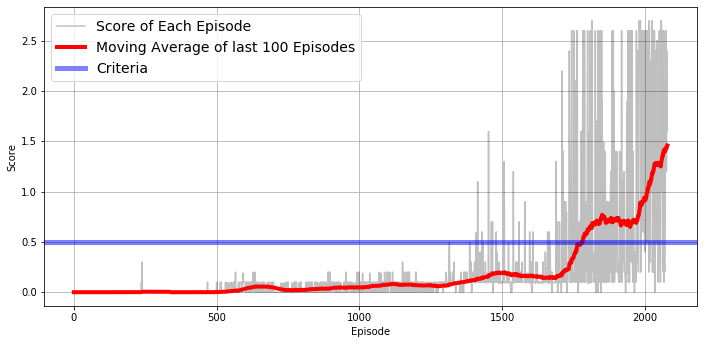

In [6]:
### 
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

#scores_rolling = pd.Series(All_scores).rolling(100).mean()
ax.plot(All_scores, "-", c="black", alpha=0.25)
ax.plot(Rolling_avg_scores, "-", c="red", linewidth=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(TARGET_SCORE, c="blue", linewidth=5, alpha=0.5)
ax.legend(["Score of Each Episode", "Moving Average of last 100 Episodes", "Criteria"])

fig.tight_layout()
fig.savefig("result_score1.jpg")

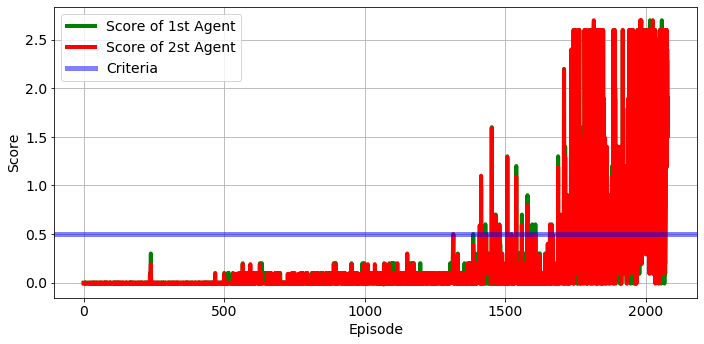

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

ax.plot(Agent1_scores, "-", c="green", linewidth=4)
ax.plot(Agent2_scores , "-", c="red",  linewidth=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(TARGET_SCORE, c="blue", linewidth=5, alpha=0.5)
ax.legend(["Score of 1st Agent", "Score of 2st Agent", "Criteria"])

fig.tight_layout()
fig.savefig("result_score2.jpg")

In [3]:
#Watch trained Agents by multi-agent d4pg 
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


Agent1_Actor_checkpoint_latest_file  = "Agent1_Actor_checkpoint_latest.pth"
Agent2_Actor_checkpoint_latest_file  = "Agent2_Actor_checkpoint_latest.pth"

multiagent = multiAgent(state_size=state_size, action_size=action_size, seed=42, 
                        BUFFER_SIZE=int(1e6), BATCH_SIZE=64, GAMMA=0.97, TAU=1e-3, 
                        LR_ACTOR=5e-4, LR_CRITIC=5e-4, WEIGHT_DECAY=0.0, UPDATE_EVERY=2, N_step=5)

multiagent.d4pg_Agents[0].actor_local.load_state_dict(torch.load(Agent1_Actor_checkpoint_latest_file), strict=False)
multiagent.d4pg_Agents[1].actor_local.load_state_dict(torch.load(Agent2_Actor_checkpoint_latest_file), strict=False)


for i in range(1, 4):                                      # play game for 3 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(2)                                   # initialize the score (for each agent)
    while True:
        actions = multiagent.acts(states)                  # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
    
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Score (max over agents) from episode 1: 0.7000000104308128
Score (max over agents) from episode 2: 0.9000000134110451
Score (max over agents) from episode 3: 1.2000000178813934


When finished, you can close the environment.